**Kate Groschner** <br>
**AY250 Homework 6**

## Question 1

**Feature 1**

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage 
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
import skimage.color
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
import cv2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm

def import_exImg():
    sample_images = {}
    if os.getcwd().split('/')[-1] != '50_categories':
        exit()
    files = os.listdir()
    for idx, direct in enumerate(files):
        if idx == 0:
            pass
        else:
            os.chdir(direct)
            file = os.listdir()[0]
            img = io.imread(file)
            sample_images[direct] = img
            os.chdir('..')
    print('Done!')
    return(sample_images)

def avg_red(img):
    """returns average value of red channel"""
    avg = [img[:,0].mean()]
    return np.array(avg)

def avg_blue(img):
    """returns average value of blue channel"""
    avg = [img[:,1].mean()]
    return np.array(avg)

def avg_green(img):
    """returns average value of green channel"""
    avg = [img[:,2].mean()]
    return np.array(avg)

# edges from sobel
def sobel_edges(gray_image):
    """Returns histogram of edges and average of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges,bins=250, density = True)[0]
    return edge_hist

# number of blobs from difference of gaussian
def blobs_dog(gray_image):
    """returns two features: average blob size and total number of blobs detected by difference of gaussians"""
    blob = skimage.feature.blob_dog(gray_image, max_sigma=50, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image, max_sigma=5, num_sigma=10, threshold=.1)
    blobs = blob[:,2]
    avg_blob = blobs.mean()
    num_blobs = len(blobs)
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 250 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=250,density = True)[0]
    return fhist

def lbp_hist(gray_image):
    """returns 250 bin histogram of local binary patterns from image"""
    print(gray_image.shape)
    lbp = skimage.feature.local_binary_pattern(gray_image,30,30)
    lhist = np.histogram(lbp,bins=250,density = True)[0]
    return lhist

def center_cut(image):
    """returns a 1d array of length 1200 which is 20x20 center of image of all three channels flattened"""
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10),:].flatten()
    return cut

def avg_HSV(image):
    """returns the average for hue, saturation, and value from image"""
    img_out = skimage.color.rgb2hsv(image)
    results = [img_out[:,:,0].mean(),img_out[:,:,1].mean(),img_out[:,:,2].mean()]
    return np.array(results)

def sift10(image):
    """returns 1d array of length 1280 which represents the first 10 SIFT features of the image"""
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(image,None)
    if des.shape[0] <= 10:
        dif = 10 - des.shape[0]
        filler = np.zeros((dif,128))
        sift = np.concatenate((des,filler),axis=0).flatten()
    else:
        sift = des[:10,:].flatten()
    return sift

def color_hist(image):
    """returns 1d array of length 300 representing the color histogram for red,blue, and green channels"""
    hist = []
    if len(image.shape) == 3:
        for i in range(0,3):
            hist.append(np.histogram(image[:,:,i],bins=100, density = True)[0])
    else:
        for i in range(0,3):
            hist.append(np.histogram(image,bins=100, density = True)[0])
    hist = np.concatenate(hist)
    return hist

def get_features(file):
    image = io.imread(file)
    label = file.parent.name
    gray_image = rgb2gray(image)
#     print(file)
    features = [] 
    features.append(color_hist(image))
    features.append(sift10(image))
    features.append(avg_HSV(image))
    features.append(center_cut(image))
    features.append(lbp_hist(gray_image))
    features.append(fft_hist(gray_image))
    features.append(blobs_log(gray_image))
    features.append(blobs_dog(gray_image))
    features.append(sobel_edges(gray_image))
    features.append(avg_green(image))
    features.append(avg_blue(image))
    features.append(avg_red(image))
    features = np.concatenate(features)
    return (features,label)


In [2]:
def feature_frame(directory):
    files = list(Path(directory).glob('*/*.jpg'))
    np.random.seed(42)
    file_list = np.random.choice(files,100)
    features = Parallel(n_jobs=-1)(delayed(get_features)(file) for file in tqdm(file_list))
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    df['Label'] = labels_list
    return df

In [3]:
directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
df = feature_frame(directory)
csv_name = directory + '/features.csv'
df.to_csv(csv_name)

  0%|          | 0/100 [00:00<?, ?it/s]

(196, 160)
(192, 256)
(195, 258)
(154, 410)


  8%|▊         | 8/100 [00:00<00:05, 16.77it/s]

(300, 650)


  9%|▉         | 9/100 [00:00<00:08, 10.26it/s]

(360, 240)


 10%|█         | 10/100 [00:01<00:10,  8.24it/s]

(200, 300)


 11%|█         | 11/100 [00:01<00:12,  7.40it/s]

(164, 404)


 12%|█▏        | 12/100 [00:01<00:13,  6.39it/s]

(600, 406)


 13%|█▎        | 13/100 [00:02<00:14,  6.10it/s]

(120, 160)
(366, 536)


 15%|█▌        | 15/100 [00:02<00:13,  6.13it/s]

(225, 300)


 16%|█▌        | 16/100 [00:02<00:15,  5.49it/s]

(164, 240)


 17%|█▋        | 17/100 [00:03<00:16,  5.01it/s]

(150, 198)


 18%|█▊        | 18/100 [00:03<00:16,  4.87it/s]

(480, 640)


 19%|█▉        | 19/100 [00:04<00:20,  3.95it/s]

(194, 260)


 20%|██        | 20/100 [00:05<00:21,  3.64it/s]

(221, 395)


 21%|██        | 21/100 [00:06<00:22,  3.49it/s]

(450, 397)


 22%|██▏       | 22/100 [00:06<00:21,  3.56it/s]

(128, 192)


 23%|██▎       | 23/100 [00:06<00:21,  3.57it/s]

(500, 380)


 24%|██▍       | 24/100 [00:06<00:21,  3.61it/s]

(630, 650)


 25%|██▌       | 25/100 [00:08<00:24,  3.01it/s]

(291, 450)


 26%|██▌       | 26/100 [00:08<00:25,  2.95it/s]

(478, 640)


 27%|██▋       | 27/100 [00:09<00:26,  2.71it/s]

(155, 401)
(212, 300)


 29%|██▉       | 29/100 [00:10<00:26,  2.71it/s]

(584, 880)


 30%|███       | 30/100 [00:12<00:30,  2.31it/s]

(500, 377)


 31%|███       | 31/100 [00:13<00:29,  2.33it/s]

(240, 350)


 32%|███▏      | 32/100 [00:14<00:30,  2.22it/s]

(480, 640)


 33%|███▎      | 33/100 [00:16<00:33,  2.00it/s]

(148, 180)


 34%|███▍      | 34/100 [00:16<00:32,  2.03it/s]

(165, 270)


 35%|███▌      | 35/100 [00:16<00:31,  2.06it/s]

(450, 317)


 36%|███▌      | 36/100 [00:17<00:30,  2.08it/s]

(321, 527)


 37%|███▋      | 37/100 [00:17<00:30,  2.06it/s]

(286, 300)


Jobliberror: Jobliberror
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10e3566f0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kategroschner/anaconda/lib/python3.6/site...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kateg.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10e3566f0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/kategroschner/anaconda/lib/python3.6/site...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/kateg.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 if __name__ == '__main__':
      2     from ipykernel import kernelapp as app
----> 3     app.launch_new_instance()

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 23, 29, 15, 800200, tzinfo=tzutc()), 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'session': '8997CB4CA69341CA920E79F00F19268B', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'8997CB4CA69341CA920E79F00F19268B']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 23, 29, 15, 800200, tzinfo=tzutc()), 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'session': '8997CB4CA69341CA920E79F00F19268B', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'8997CB4CA69341CA920E79F00F19268B'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 3, 26, 23, 29, 15, 800200, tzinfo=tzutc()), 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'session': '8997CB4CA69341CA920E79F00F19268B', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'EF01624D24684B2AB244186A2B83CB36', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-3-3c3da32fa43c>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 110ad3b00, execution_..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x12714ff60, file "<ipython-input-3-3c3da32fa43c>", line 2>
        result = <ExecutionResult object at 110ad3b00, execution_..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x12714ff60, file "<ipython-input-3-3c3da32fa43c>", line 2>, result=<ExecutionResult object at 110ad3b00, execution_..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x12714ff60, file "<ipython-input-3-3c3da32fa43c>", line 2>
        self.user_global_ns = {'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...concatenate(features)\n    return (features,label)", "def feature_frame(directory):\n    files = list(P...list)\n    df['Label'] = labels_list\n    return df", "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)"], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'Path': <class 'pathlib.Path'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'In': ['', "get_ipython().run_line_magic('matplotlib', 'inli...concatenate(features)\n    return (features,label)", "def feature_frame(directory):\n    files = list(P...list)\n    df['Label'] = labels_list\n    return df", "directory = '/Users/kategroschner/Documents/Berk...= directory + '/features.csv'\ndf.to_csv(csv_name)"], 'Out': {}, 'Parallel': <class 'joblib.parallel.Parallel'>, 'Path': <class 'pathlib.Path'>, '_': '', '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/<ipython-input-3-3c3da32fa43c> in <module>()
      1 directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
----> 2 df = feature_frame(directory)
      3 csv_name = directory + '/features.csv'
      4 df.to_csv(csv_name)

...........................................................................
/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/<ipython-input-2-80b207d14d44> in feature_frame(directory='/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories')
      1 def feature_frame(directory):
      2     files = list(Path(directory).glob('*/*.jpg'))
      3     np.random.seed(42)
      4     file_list = np.random.choice(files,100)
----> 5     features = Parallel(n_jobs=-1)(delayed(get_features)(file) for file in tqdm(file_list))
      6     print('Done!')
      7     feat_list, labels_list = zip(*features)
      8     df = pd.DataFrame.from_records(feat_list)
      9     df['Label'] = labels_list
     10     return df

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object feature_frame.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
error                                              Mon Mar 26 16:29:31 2018
PID: 37974           Python 3.6.4: /Users/kategroschner/anaconda/bin/python
...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function get_features>, (PosixPath('/Users/kategroschner/Documents/Berkel...-homework/hw_6/50_categories/duck/duck_0049.jpg'),), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kategroschner/anaconda/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function get_features>
        args = (PosixPath('/Users/kategroschner/Documents/Berkel...-homework/hw_6/50_categories/duck/duck_0049.jpg'),)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/<ipython-input-1-cc56337aebc0> in get_features(file=PosixPath('/Users/kategroschner/Documents/Berkel...-homework/hw_6/50_categories/duck/duck_0049.jpg'))
    129     gray_image = rgb2gray(image)
    130 #     print(file)
    131     features = [] 
    132     features.append(color_hist(image))
    133     features.append(sift10(image))
--> 134     features.append(avg_HSV(image))
    135     features.append(center_cut(image))
    136     features.append(lbp_hist(gray_image))
    137     features.append(fft_hist(gray_image))
    138     features.append(blobs_log(gray_image))

...........................................................................
/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/<ipython-input-1-cc56337aebc0> in avg_HSV(image=array([[234, 236, 238, ..., 213, 213, 216],
    ...226, 233, 239, ..., 206, 205, 201]], dtype=uint8))
     93     cut = image[(middle[0]-10):(middle[0]+10),(middle[1]-10):(middle[1]+10),:].flatten()
     94     return cut
     95 
     96 def avg_HSV(image):
     97     """returns the average for hue, saturation, and value from image"""
---> 98     img_out = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
     99     results = [img_out[0].mean(),img_out[1].mean(),img_out[2].mean()]
    100     return np.array(results)
    101 
    102 def sift10(image):

error: OpenCV(3.4.1) /Users/travis/miniconda3/conda-bld/opencv_1520726505330/work/opencv-3.4.1/modules/imgproc/src/color.cpp:11214: error: (-215) (scn == 3 || scn == 4) && (depth == 0 || depth == 5) in function cvtColor

___________________________________________________________________________

In [4]:
np.random.seed(42)
files = list(Path(directory).glob('*/*.jpg'))
file_list = np.random.choice(files,100)
file_list[37]

PosixPath('/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories/horse/horse_0034.jpg')

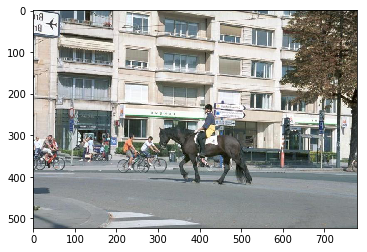

In [5]:
a = io.imread(file_list[37])
plt.imshow(a)

In [6]:
a.shape

(523, 778, 3)

In [10]:
b = color_hist(a)

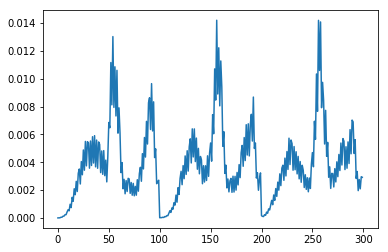

In [11]:
plt.plot(b)